In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cbio-gee/EmissoesBrutasGEE.csv
/kaggle/input/cbio-gee/ICBIO_csv.csv


In [2]:

# -*- coding: utf-8 -*-
"""
Análise CBIO – gráficos separados e gráfico final combinado com melhor modelo.
Saídas em: ./plots_cbio_separados/
"""

import os
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
FIG_DPI = 150
OUT_DIR = "plots_cbio_separados"
os.makedirs(OUT_DIR, exist_ok=True)

In [3]:
# -------------------------------
# 0) Utilitários e carregamento
# -------------------------------
CSV_CBIO = "/kaggle/input/cbio-gee/ICBIO_csv.csv"
CSV_EXOG = "/kaggle/input/cbio-gee/EmissoesBrutasGEE.csv"

def strip_accents(s: str) -> str:
    return "".join(c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn")

def load_cbio_series(csv_path=CSV_CBIO):
    """Lê o CSV do Índice CBIO, remove duplicidades e reindexa para dias úteis."""
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Arquivo {csv_path} não encontrado.")
    df = pd.read_csv(csv_path, sep=';', decimal=',')
    df.columns = [c.strip().replace('\ufeff','') for c in df.columns]
    df['Data_Referencia'] = pd.to_datetime(df['Data_Referencia'], format='%d-%m-%Y', errors='coerce')
    df['Indice'] = pd.to_numeric(df['Indice'], errors='coerce')
    df = df.sort_values('Data_Referencia').drop_duplicates(subset=['Data_Referencia'], keep='last')
    ts = df.set_index('Data_Referencia')['Indice'].sort_index()
    b_index = pd.date_range(ts.index.min(), ts.index.max(), freq='B')
    return ts.reindex(b_index).ffill().bfill()

def load_exog_producao_comb_robusto(csv_path=CSV_EXOG):
    """
    Lê EmissoesBrutasGEE.csv pulando a 1ª linha decorativa, encontra a linha
    'Produção de combustíveis' de forma robusta e retorna série anual (anos -> float).
    """
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Arquivo {csv_path} não encontrado.")
    df = pd.read_csv(csv_path, sep=';', decimal=',', skiprows=1, header=0, engine='python')
    df.columns = [str(c).strip() for c in df.columns]
    primeira_col = df.columns[0]  # 'Atividade geral'
    df = df.set_index(primeira_col)
    df.index = [str(i).strip() for i in df.index]
    idx_match = None
    for idx in df.index:
        idx_norm = strip_accents(idx.lower())
        if "producao" in idx_norm and "combust" in idx_norm:
            idx_match = idx
            break
    if idx_match is None:
        raise ValueError("Linha 'Produção de combustíveis' não encontrada no CSV.")
    row = df.loc[idx_match]
    cols_year = [c for c in row.index if str(c).strip().isdigit()]
    series_year = pd.to_numeric(row[cols_year], errors='coerce').dropna()
    series_year.index = series_year.index.astype(int)
    return series_year

# Carregar séries
ts_b = load_cbio_series(CSV_CBIO)
exog_year = load_exog_producao_comb_robusto(CSV_EXOG)

# Mapear exógena anual para cada dia útil
exog_daily = pd.Series(index=ts_b.index, data=[exog_year.get(d.year, np.nan) for d in ts_b.index]).ffill().bfill()

# DataFrame combinado (alvo + exógena)
df_all = pd.DataFrame({'Indice': ts_b, 'Produção_de_combustíveis': exog_daily}).dropna()

# Split temporal 80/20
N = len(df_all)
H = int(np.ceil(0.20 * N))
train = df_all.iloc[:-H].copy()
test  = df_all.iloc[-H:].copy()

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error
def rmse(y_true, y_pred): return float(np.sqrt(mean_squared_error(y_true, y_pred)))
def mae(y_true, y_pred):  return float(mean_absolute_error(y_true, y_pred))
def smape(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred); denom = np.where(denom==0, 1e-8, denom)
    return float(100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom))



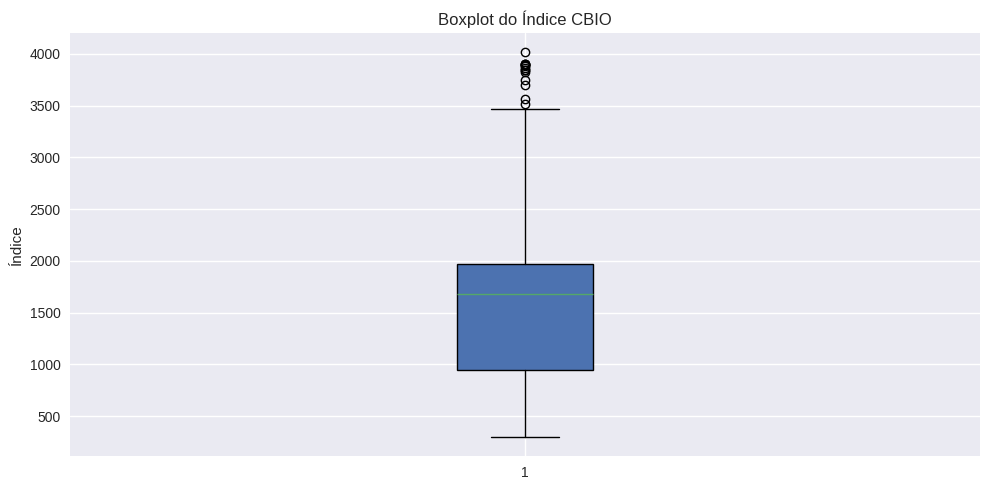

In [4]:
# -------------------------------
# 1) Gráficos de exploração
# -------------------------------

# 1.1 Boxplot
plt.figure(figsize=(10,5))
plt.boxplot(df_all['Indice'].values, vert=True, patch_artist=True)
plt.title('Boxplot do Índice CBIO')
plt.ylabel('Índice')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "01_boxplot_indice.png"), dpi=FIG_DPI)
plt.show()


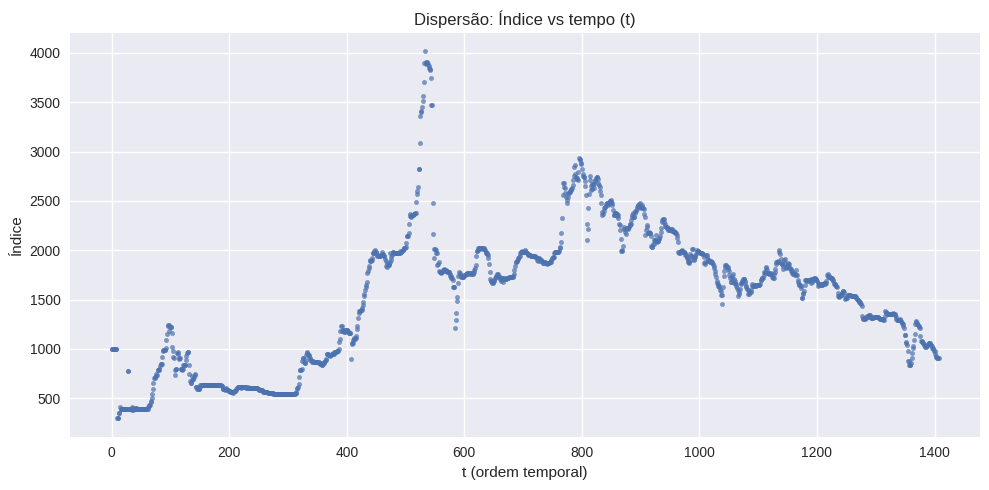

In [5]:

# 1.2 Dispersão vs tempo
t = np.arange(len(df_all))
plt.figure(figsize=(10,5))
plt.scatter(t, df_all['Indice'].values, s=10, alpha=0.7)
plt.title('Dispersão: Índice vs tempo (t)')
plt.xlabel('t (ordem temporal)')
plt.ylabel('Índice')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "02_scatter_vs_t.png"), dpi=FIG_DPI)
plt.show()


/tmp/ipykernel_17/1242043607.py:8: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_17/1242043607.py:9: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  plt.savefig(os.path.join(OUT_DIR, "03_scatter_vs_exog.png"), dpi=FIG_DPI)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


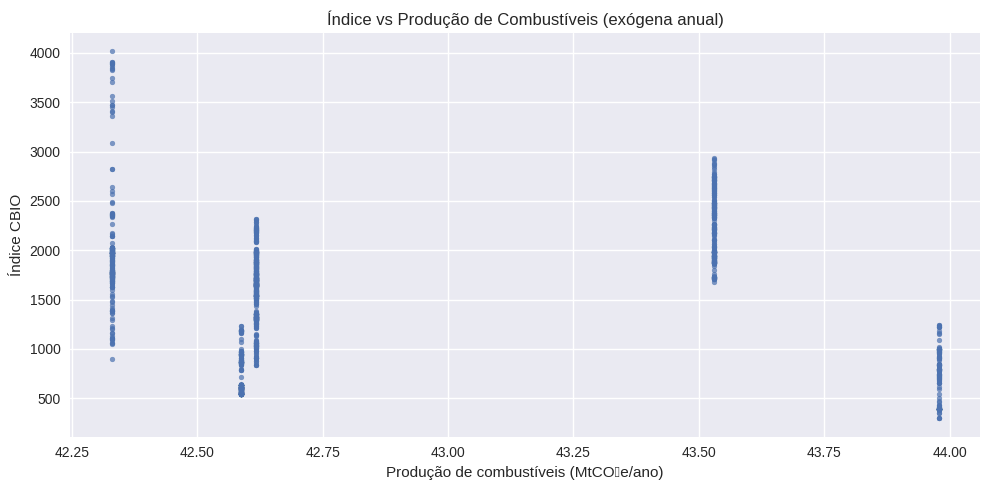

In [6]:
# 1.3 Dispersão vs exógena
tmp_sc = df_all[['Indice','Produção_de_combustíveis']].dropna()
plt.figure(figsize=(10,5))
plt.scatter(tmp_sc['Produção_de_combustíveis'].values, tmp_sc['Indice'].values, s=12, alpha=0.7)
plt.title('Índice vs Produção de Combustíveis (exógena anual)')
plt.xlabel('Produção de combustíveis (MtCO₂e/ano)')
plt.ylabel('Índice CBIO')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "03_scatter_vs_exog.png"), dpi=FIG_DPI)
plt.show()


In [7]:
# 1.4 ADF (texto no console)
from statsmodels.tsa.stattools import adfuller
adf_stat, adf_pvalue, adf_usedlag, adf_nobs, adf_crit, adf_icbest = adfuller(df_all['Indice'].values, autolag='AIC')
print("\n[ADF] Teste Dickey-Fuller em nível:")
print(f"Estatística: {adf_stat:.4f} | p-valor: {adf_pvalue:.6f} | lags: {adf_usedlag} | nobs: {adf_nobs}")
print("Críticos:", adf_crit)



[ADF] Teste Dickey-Fuller em nível:
Estatística: -1.9892 | p-valor: 0.291318 | lags: 23 | nobs: 1384
Críticos: {'1%': np.float64(-3.4350837211576697), '5%': np.float64(-2.863630592595516), '10%': np.float64(-2.5678830271851716)}


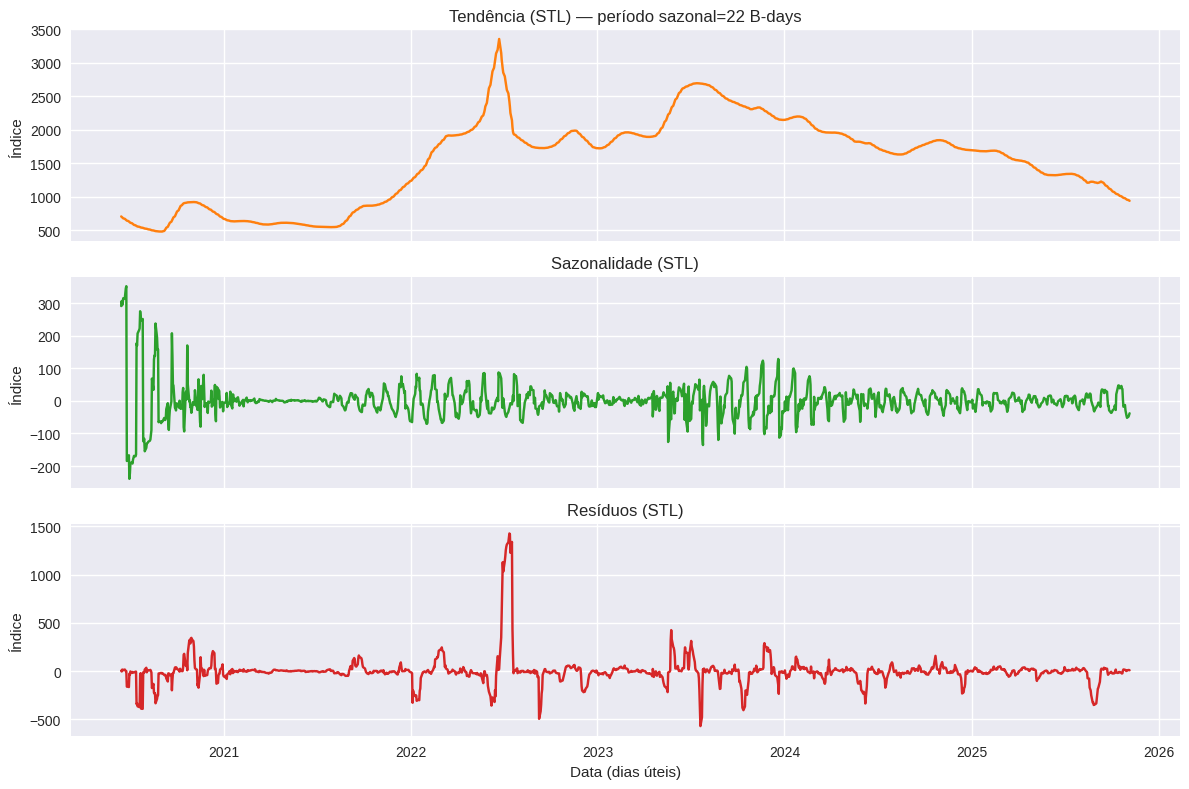

[STL] Período selecionado: 22 B-days | força sazonal=0.000


In [8]:
# -------------------------------
# 2) STL – seleção automática da sazonalidade
# -------------------------------
from statsmodels.tsa.seasonal import STL

def seasonal_strength(stl_result):
    remainder = stl_result.resid
    seasonal  = stl_result.seasonal
    denom = np.var(remainder + seasonal)
    return float(1.0 - (np.var(remainder) / denom)) if denom > 0 else 0.0

candidate_periods = [5, 7, 21, 22, 30, 60, 252]
stl_summary = []
for p in candidate_periods:
    res = STL(df_all['Indice'], period=p, robust=True).fit()
    stl_summary.append((p, seasonal_strength(res), float(np.var(res.resid)), res))
best_period, best_strength, best_residvar, best_res = sorted(stl_summary, key=lambda kv:(-kv[1], kv[2]))[0]

fig, axes = plt.subplots(3,1, figsize=(12,8), sharex=True)
axes[0].plot(best_res.trend.index, best_res.trend.values, color='tab:orange'); axes[0].set_title(f'Tendência (STL) — período sazonal={best_period} B-days')
axes[1].plot(best_res.seasonal.index, best_res.seasonal.values, color='tab:green');  axes[1].set_title('Sazonalidade (STL)')
axes[2].plot(best_res.resid.index, best_res.resid.values, color='tab:red');           axes[2].set_title('Resíduos (STL)')
for ax in axes: ax.set_ylabel('Índice')
axes[-1].set_xlabel('Data (dias úteis)')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "04_stl_decomp_best.png"), dpi=FIG_DPI)
plt.show()
print(f"[STL] Período selecionado: {best_period} B-days | força sazonal={best_strength:.3f}")



In [9]:
# -------------------------------
# 3) Modelagem – Holt, Theta, SARIMAX, LSTM
# -------------------------------
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Design consistente com constante
X_tr_df = sm.add_constant(train[['Produção_de_combustíveis']].astype(float), has_constant='add')
X_te_df = sm.add_constant(test[['Produção_de_combustíveis']].astype(float),  has_constant='add')
y_tr = train['Indice'].astype(float)
y_te = test['Indice'].astype(float)

ols_res = sm.OLS(y_tr.values, X_tr_df.values).fit()
resid_tr = y_tr.values - ols_res.predict(X_tr_df.values)
reg_part_te = ols_res.predict(X_te_df.values)



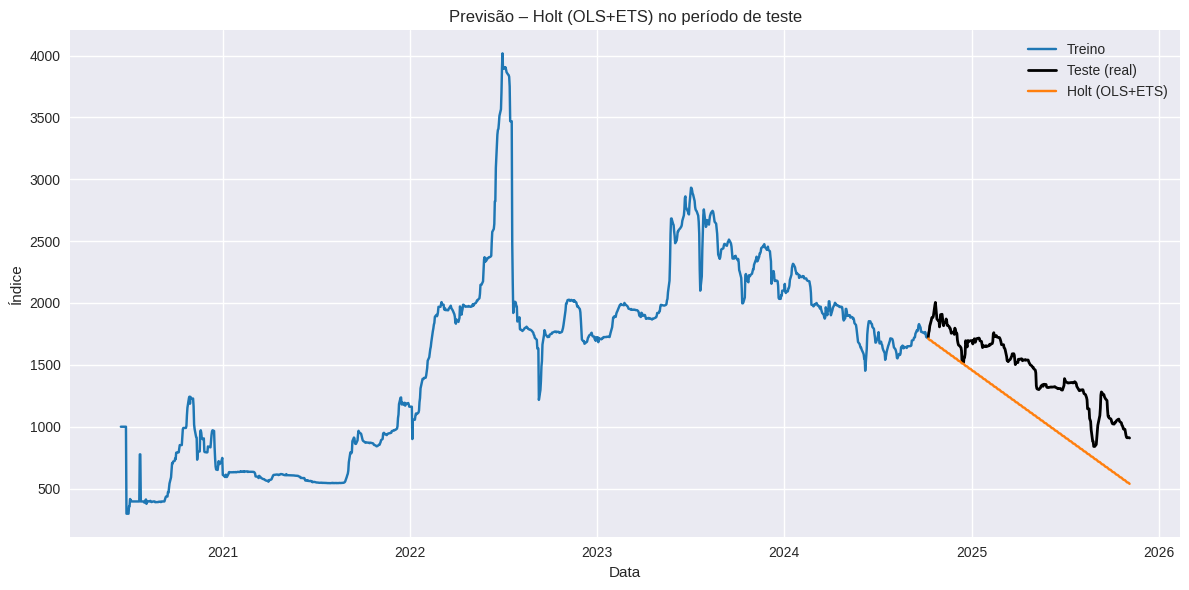

In [10]:
# 3.1 Holt (ETS) nos resíduos – gráfico isolado
holt_model = ExponentialSmoothing(pd.Series(resid_tr, index=train.index), trend='add', seasonal=None, damped_trend=False).fit(optimized=True)
resid_fc_holt = holt_model.forecast(len(test)).values
yhat_holt = reg_part_te + resid_fc_holt

plt.figure(figsize=(12,6))
plt.plot(train.index, train['Indice'].values, label='Treino', color='tab:blue')
plt.plot(test.index,  test['Indice'].values,  label='Teste (real)', color='black', linewidth=2)
plt.plot(test.index,  yhat_holt,              label='Holt (OLS+ETS)', color='tab:orange')
plt.title('Previsão – Holt (OLS+ETS) no período de teste')
plt.xlabel('Data'); plt.ylabel('Índice')
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "05_holt_fc.png"), dpi=FIG_DPI)
plt.show()

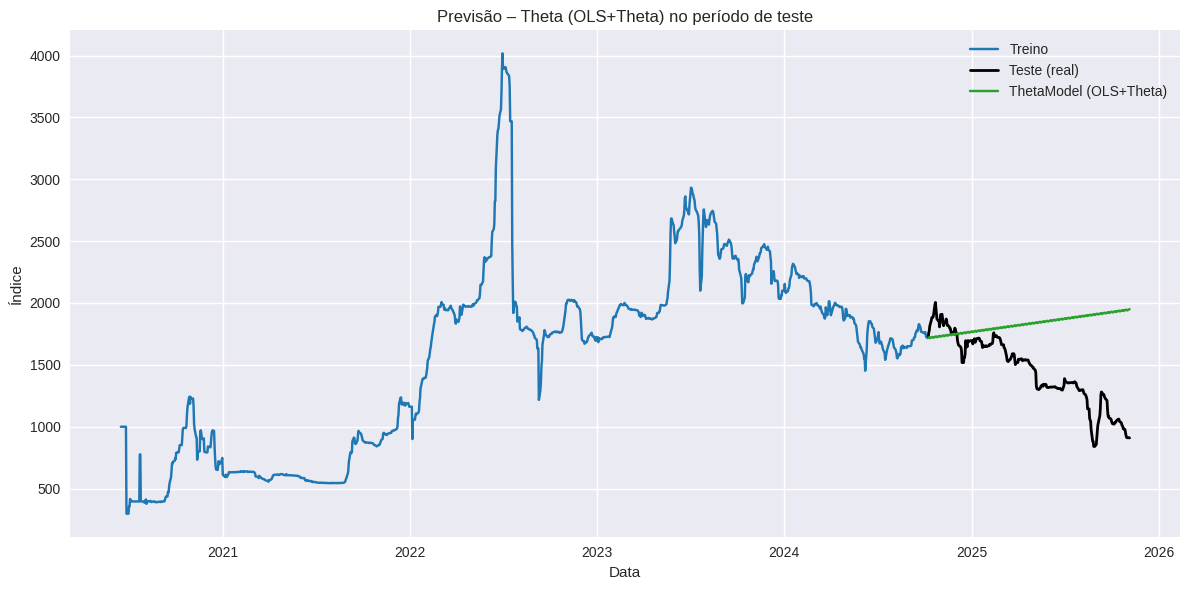

In [11]:
# 3.2 Theta nos resíduos – gráfico isolado
try:
    from statsmodels.tsa.forecasting.theta import ThetaModel
    theta_res = ThetaModel(pd.Series(resid_tr, index=train.index)).fit()
    resid_fc_theta = theta_res.forecast(len(test)).values
    theta_name = "ThetaModel"
except Exception:
    from statsmodels.tsa.holtwinters import SimpleExpSmoothing
    ses = SimpleExpSmoothing(pd.Series(resid_tr, index=train.index)).fit(optimized=True)
    ses_fc = ses.forecast(len(test)).values
    t_idx = np.arange(len(resid_tr))
    slope = np.polyfit(t_idx, resid_tr, 1)[0]
    resid_fc_theta = ses_fc + (np.arange(1, len(test)+1)*slope)/2.0
    theta_name = "Theta(SES+drift)"

yhat_theta = reg_part_te + resid_fc_theta

plt.figure(figsize=(12,6))
plt.plot(train.index, train['Indice'].values, label='Treino', color='tab:blue')
plt.plot(test.index,  test['Indice'].values,  label='Teste (real)', color='black', linewidth=2)
plt.plot(test.index,  yhat_theta,             label=f'{theta_name} (OLS+Theta)', color='tab:green')
plt.title('Previsão – Theta (OLS+Theta) no período de teste')
plt.xlabel('Data'); plt.ylabel('Índice')
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "06_theta_fc.png"), dpi=FIG_DPI)
plt.show()



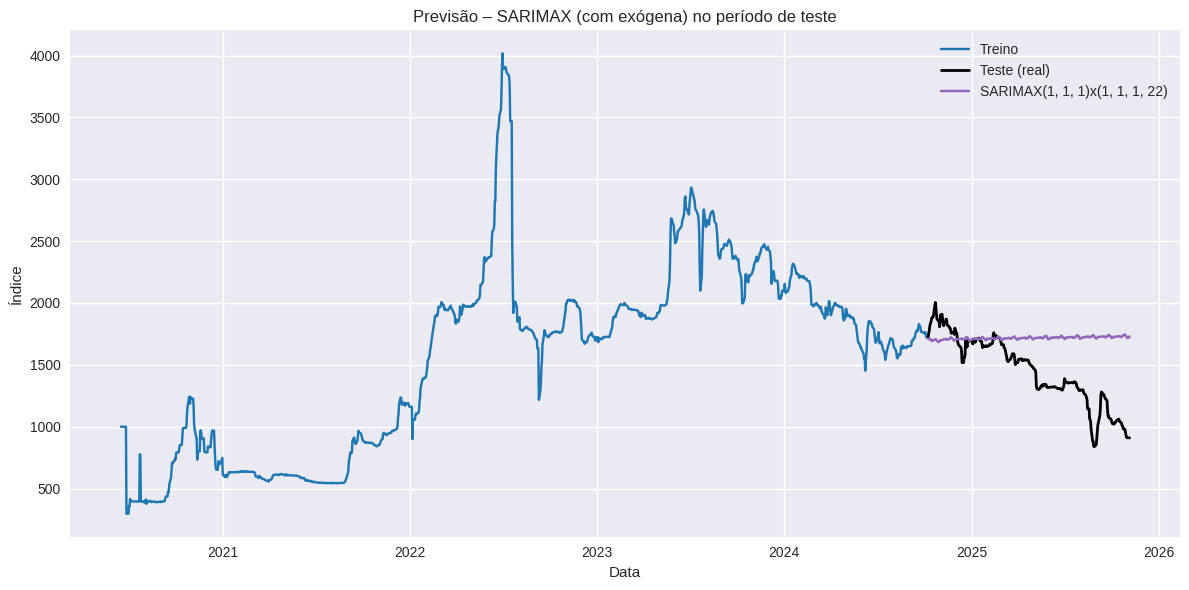

In [12]:
# 3.3 SARIMAX com exógena – gráfico isolado
m = int(best_period);  m = 30 if m>60 else m
order_init, seasonal_init = (1,1,1), (1,1,1,m)
model_sar = SARIMAX(
    train['Indice'].astype(float),
    order=order_init, seasonal_order=seasonal_init,
    exog=train[['Produção_de_combustíveis']].astype(float),
    enforce_stationarity=False, enforce_invertibility=False
).fit(disp=False)

sar_fc = model_sar.forecast(steps=len(test), exog=test[['Produção_de_combustíveis']].astype(float))
yhat_sarima = sar_fc.values

plt.figure(figsize=(12,6))
plt.plot(train.index, train['Indice'].values, label='Treino', color='tab:blue')
plt.plot(test.index,  test['Indice'].values,  label='Teste (real)', color='black', linewidth=2)
plt.plot(test.index,  yhat_sarima,            label=f"SARIMAX{order_init}x{seasonal_init}", color='tab:purple')
plt.title('Previsão – SARIMAX (com exógena) no período de teste')
plt.xlabel('Data'); plt.ylabel('Índice')
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "07_sarimax_fc.png"), dpi=FIG_DPI)
plt.show()


2025-12-30 16:16:18.885674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767111379.273225      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767111379.398489      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767111380.432257      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767111380.432300      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767111380.432304      17 computation_placer.cc:177] computation placer alr

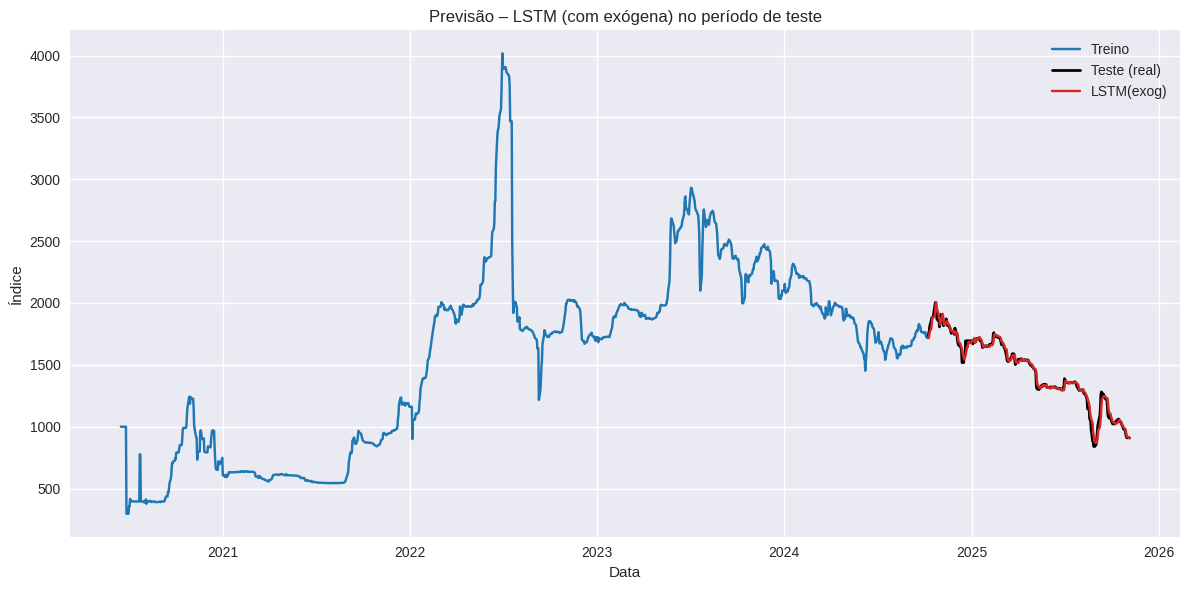

In [13]:
# 3.4 LSTM com exógena – gráfico isolado (opcional)
lstm_ok = True
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    from tensorflow.keras.callbacks import EarlyStopping
    from sklearn.preprocessing import MinMaxScaler

    WINDOW = max(30, m)  # janela ~ mensal de negócios
    df_feat = df_all.copy()
    for k in range(1, WINDOW+1):
        df_feat[f'lag_{k}'] = df_feat['Indice'].shift(k)
    df_feat = df_feat.dropna()

    split_point = len(df_feat) - len(test)  # mesmo H do teste
    train_feat = df_feat.iloc[:split_point]
    test_feat  = df_feat.iloc[split_point:]

    scaler_y = MinMaxScaler()
    scaler_X = MinMaxScaler()
    y_train_arr = scaler_y.fit_transform(train_feat[['Indice']].values)
    X_train_arr = scaler_X.fit_transform(train_feat.drop(columns=['Indice']).values)
    y_test_arr  = scaler_y.transform(test_feat[['Indice']].values)
    X_test_arr  = scaler_X.transform(test_feat.drop(columns=['Indice']).values)

    X_train_seq = X_train_arr.reshape((X_train_arr.shape[0], 1, X_train_arr.shape[1]))
    X_test_seq  = X_test_arr.reshape((X_test_arr.shape[0], 1, X_test_arr.shape[1]))

    model = Sequential([
        LSTM(64, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train_seq, y_train_arr, validation_split=0.1, epochs=200, batch_size=32, verbose=0, callbacks=[es])

    yhat_test_scaled = model.predict(X_test_seq, verbose=0)
    yhat_lstm = scaler_y.inverse_transform(yhat_test_scaled).ravel()
    y_true_lstm = test_feat['Indice'].values

    plt.figure(figsize=(12,6))
    plt.plot(train.index, train['Indice'].values, label='Treino', color='tab:blue')
    plt.plot(test_feat.index, y_true_lstm,      label='Teste (real)', color='black', linewidth=2)
    plt.plot(test_feat.index, yhat_lstm,        label='LSTM(exog)', color='tab:red')
    plt.title('Previsão – LSTM (com exógena) no período de teste')
    plt.xlabel('Data'); plt.ylabel('Índice')
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "08_lstm_fc.png"), dpi=FIG_DPI)
    plt.show()

except Exception as e:
    lstm_ok = False
    print("[LSTM] Não executado – instale tensorflow para habilitar. Erro:", repr(e))



[Comparação MSE] -> {'Holt(OLS+ETS)': 120398.9126, 'ThetaModel(OLS+Theta)': 261790.912, 'SARIMAX(1, 1, 1)x(1, 1, 1, 22)': 152248.6767, 'LSTM(exog)': 1238.8523}
Melhor método: LSTM(exog) | MSE=1238.8523


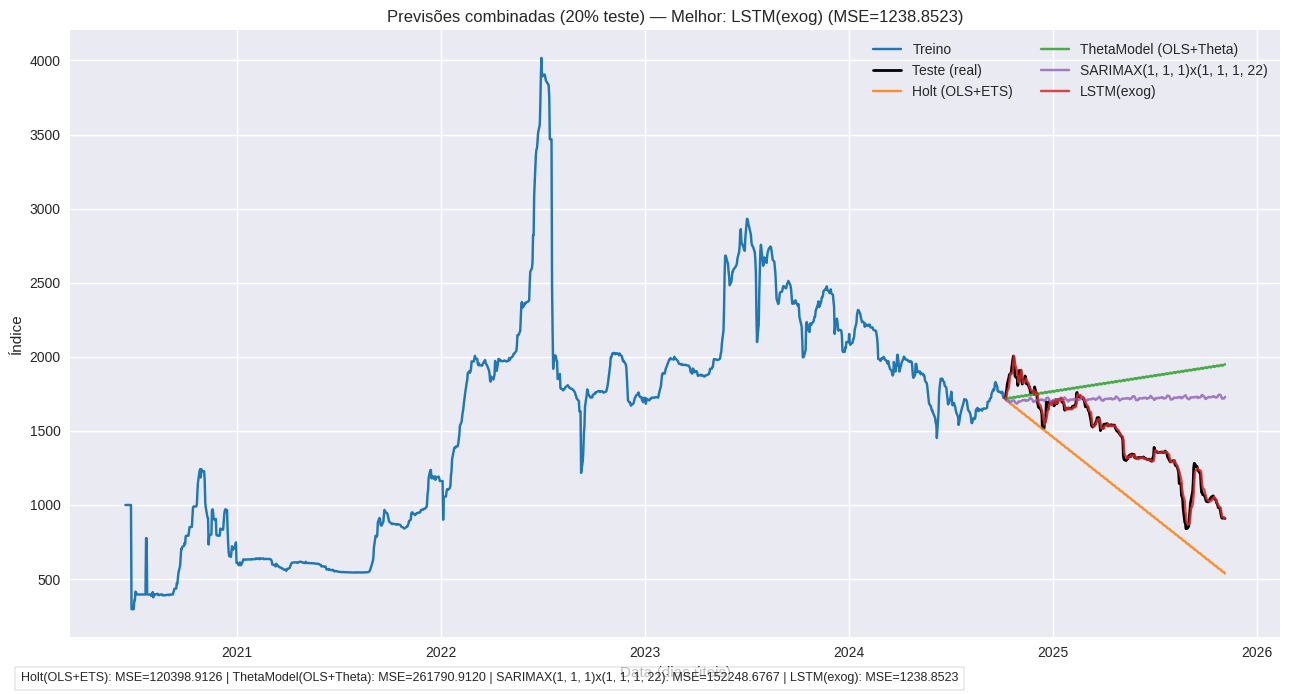


Figuras salvas em: plots_cbio_separados
Arquivos: ['01_boxplot_indice.png', '02_scatter_vs_t.png', '03_scatter_vs_exog.png', '04_stl_decomp_best.png', '05_holt_fc.png', '06_theta_fc.png', '07_sarimax_fc.png', '08_lstm_fc.png', '09_all_models_vs_test.png']


In [14]:
# -------------------------------
# 4) Métricas e gráfico combinado com melhor modelo
# -------------------------------
# Métricas por MSE para seleção do melhor
mse_dict = {
    'Holt(OLS+ETS)': mean_squared_error(y_te.values, yhat_holt),
    f'{theta_name}(OLS+Theta)': mean_squared_error(y_te.values, yhat_theta),
    f"SARIMAX{order_init}x{seasonal_init}": mean_squared_error(y_te.values, yhat_sarima),
}
# LSTM (se disponível): comparar sobre y_true_lstm e yhat_lstm
if lstm_ok:
    mse_dict['LSTM(exog)'] = mean_squared_error(y_true_lstm, yhat_lstm)

best_name = min(mse_dict, key=mse_dict.get)
best_mse  = mse_dict[best_name]
print("\n[Comparação MSE] ->", {k: round(v, 4) for k,v in mse_dict.items()})
print(f"Melhor método: {best_name} | MSE={best_mse:.4f}")

# Gráfico combinado (todos os modelos)
plt.figure(figsize=(13,7))
plt.plot(train.index, train['Indice'].values, label='Treino', color='tab:blue')
plt.plot(test.index,  test['Indice'].values,  label='Teste (real)', color='black', linewidth=2)
plt.plot(test.index,  yhat_holt,              label='Holt (OLS+ETS)', color='tab:orange', alpha=0.85)
plt.plot(test.index,  yhat_theta,             label=f'{theta_name} (OLS+Theta)', color='tab:green', alpha=0.85)
plt.plot(test.index,  yhat_sarima,            label=f"SARIMAX{order_init}x{seasonal_init}", color='tab:purple', alpha=0.85)
if lstm_ok:
    plt.plot(test_feat.index, yhat_lstm,      label='LSTM(exog)', color='tab:red', alpha=0.85)

plt.title(f'Previsões combinadas (20% teste) — Melhor: {best_name} (MSE={best_mse:.4f})')
plt.xlabel('Data (dias úteis)'); plt.ylabel('Índice')
plt.legend(ncol=2)
# Caixa de anotação com as métricas
text_lines = [f"{k}: MSE={v:.4f}" for k,v in mse_dict.items()]
plt.gcf().text(0.02, 0.02, " | ".join(text_lines), fontsize=9, bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "09_all_models_vs_test.png"), dpi=FIG_DPI)
plt.show()

print("\nFiguras salvas em:", OUT_DIR)
print("Arquivos:", sorted(os.listdir(OUT_DIR)))